# Automating Contract Review With Transformer Models

##### Task 1: Import the Libraries

In [1]:
import json
import os
import torch
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


##### Task 2: Generate Dataset Files

In [3]:
# Write convert_json_to_csv() function.
def convert_json_to_csv(json_file, csv_file, count):
    text_list = []
    hypothesis_list = []
    labels_list = []
    counter : int = 0
    with open(json_file, 'r') as f:
        data = json.load(f)
    for document in data['documents']:
        annotation_sets = document.get('annotation_sets',[])
        for annotation_set in annotation_sets:
            annotations = annotation_set.get('annotations')
            for annotation in annotations:
                if(count < counter):
                    break
                if isinstance(annotations[annotation], dict):
                    if 'choice' in annotations[annotation]:
                        labels_list.append(annotations[annotation]['choice'])
                        text_list.append(document['text'])
                        hypothesis_list.append(data['labels'][annotation]['hypothesis'])

                        counter+=1
                

    if(len(text_list) == len(hypothesis_list) and len(hypothesis_list) == len(labels_list)):
        df = pd.DataFrame({'text' : text_list, 'hypothesis': hypothesis_list, 'labels' : labels_list})
        df.to_csv(csv_file)







In [4]:
# Call convert_json_to_csv() function for training, validation and testing.
directory_path = "Contract-nli Dataset/"
train_file_name = "train.csv"
val_file_name = "val.csv"
test_file_name = "test.csv"

convert_json_to_csv(json_file = directory_path+"train.json", csv_file = directory_path+train_file_name, count = 35)
convert_json_to_csv(json_file = directory_path+"valid.json", csv_file = directory_path+val_file_name, count = 10)
convert_json_to_csv(json_file = directory_path+"test.json", csv_file = directory_path+test_file_name, count = 5)

##### Task 3: Calculate Dataset Statistics

In [5]:
# 1. Load the dataset
train_df = pd.read_csv(directory_path+train_file_name)
val_df = pd.read_csv(directory_path+val_file_name)
test_df = pd.read_csv(directory_path+test_file_name)

In [6]:
# 2. Display the first and last 5 rows of the training dataset
print(train_df.head())
print(train_df.tail())

   Unnamed: 0                                               text  \
0           0  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
1           1  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
2           2  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
3           3  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
4           4  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   

                                          hypothesis        labels  
0  Receiving Party shall not reverse engineer any...  NotMentioned  
1  Receiving Party shall destroy or return some C...    Entailment  
2  Agreement shall not grant Receiving Party any ...    Entailment  
3  Receiving Party shall not disclose the fact th...    Entailment  
4  Confidential Information shall only include te...  NotMentioned  
    Unnamed: 0                                               text  \
31          31  NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...   
32          32  NON-DISCLOSURE AGREEMEN

In [7]:
# 3. Display the dimension of the training data
train_df.shape

(36, 4)

In [8]:
# 4. Display a summary of the training DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  36 non-null     int64 
 1   text        36 non-null     object
 2   hypothesis  36 non-null     object
 3   labels      36 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.2+ KB


In [26]:
# 5. Print the statistical summary of the training, validation, and testing DataFrames
print(train_df.describe(include = 'all'))
print(val_df.describe(include = 'all'))
print(test_df.describe(include = 'all'))

        Unnamed: 0                                               text  \
count    36.000000                                                 36   
unique         NaN                                                  3   
top            NaN  NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
freq           NaN                                                 17   
mean     17.500000                                                NaN   
std      10.535654                                                NaN   
min       0.000000                                                NaN   
25%       8.750000                                                NaN   
50%      17.500000                                                NaN   
75%      26.250000                                                NaN   
max      35.000000                                                NaN   

                                               hypothesis      labels  
count                                              

##### Task 4: Create Visualization Function for Features

In [10]:
# Write visualize_features() function
def visualize_features(dataset, datatype, col_name, target):
    doc_lengths = dataset[col_name].apply(len)
    max_ = doc_lengths.max()
    min_ = doc_lengths.min()
    mean_ = doc_lengths.mean()
    median_ = doc_lengths.median()

    print(f"Average document length for {datatype} : {mean_}")
    print(f"Max {target} length for {datatype} : {max_}")
    print(f"Min {target} length for {datatype} : {min_}" )
    print(f"Median {target} length for {datatype} : {median_}" )
    plt.hist(doc_lengths, bins=50)
    plt.title(f"Distribution of {target} lengths for {datatype}")

    plt.xlabel(f"{target} Length" )
    plt.ylabel("Count")
    plt.show()


    

Average document length for training : 97.77777777777777
Max hypothesis length for training : 162
Min hypothesis length for training : 66
Median hypothesis length for training : 92.5


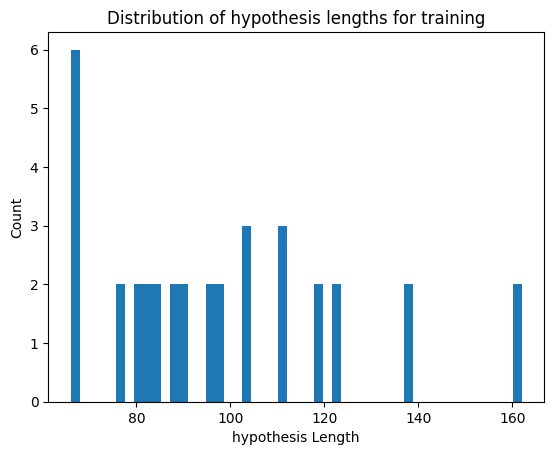

Average document length for validation : 86.54545454545455
Max hypothesis length for validation : 122
Min hypothesis length for validation : 66
Median hypothesis length for validation : 83.0


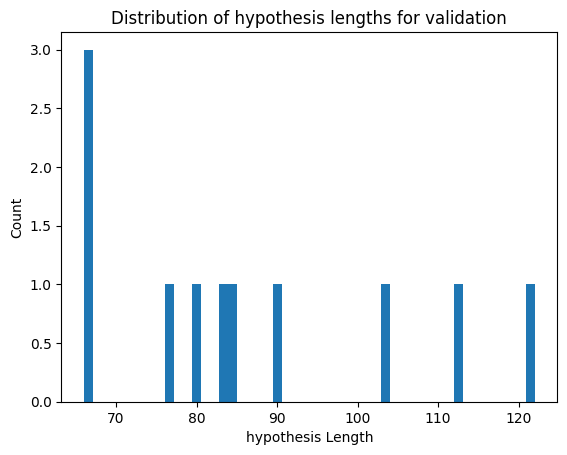

Average document length for testing : 88.16666666666667
Max hypothesis length for testing : 112
Min hypothesis length for testing : 66
Median hypothesis length for testing : 83.5


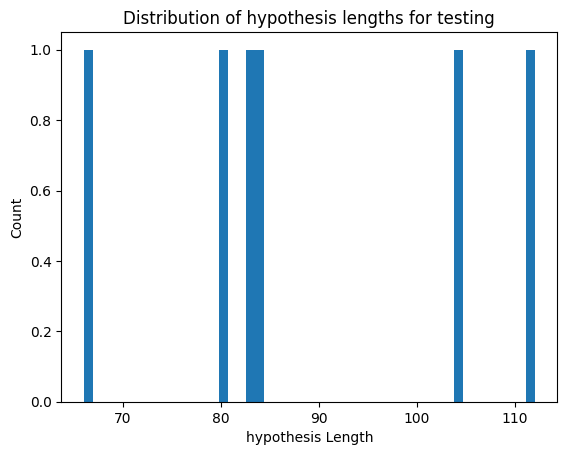

In [11]:
visualize_features(train_df, "training", "hypothesis", "hypothesis")
visualize_features(val_df, "validation", "hypothesis", "hypothesis")
visualize_features(test_df, "testing", "hypothesis", "hypothesis")

##### Task 5: Create Visualizations Function for Labels

In [12]:
# Write visualize_label() function

def visualize_label(dataset, datatype):
    print(f"The type of dataset: {datatype}")
    label_counts = dataset['labels'].value_counts()
    print(f"The count of each type of values: \n {label_counts}")

    plt.bar(label_counts.index,label_counts)
    plt.show()


The type of dataset: Training data
The count of each type of values: 
 labels
Entailment       19
NotMentioned     13
Contradiction     4
Name: count, dtype: int64


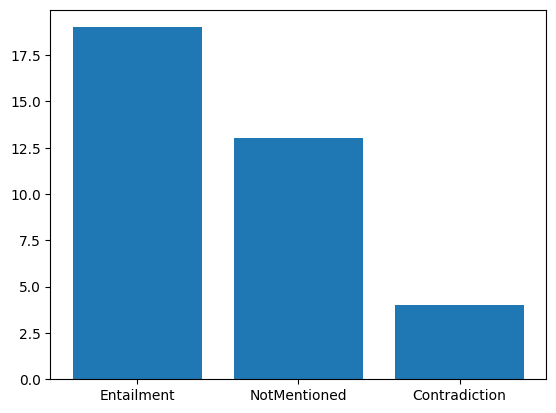

The type of dataset: Validation data
The count of each type of values: 
 labels
Entailment       9
Contradiction    1
NotMentioned     1
Name: count, dtype: int64


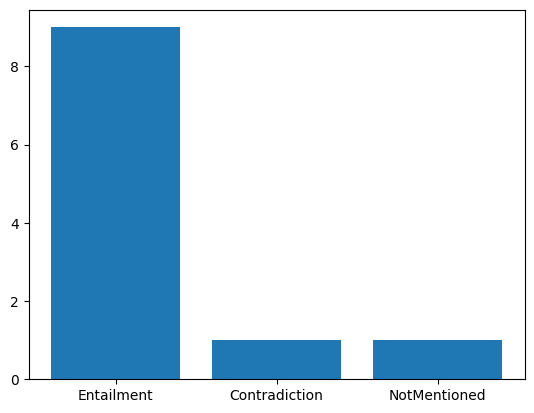

The type of dataset: Testing data
The count of each type of values: 
 labels
NotMentioned     2
Entailment       2
Contradiction    2
Name: count, dtype: int64


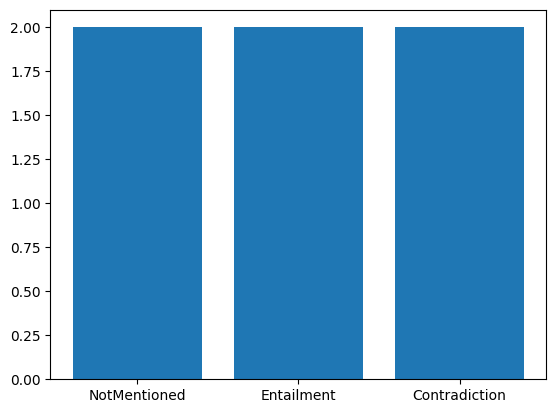

In [13]:
# Call visualize_label() function for training, validation and testing.
visualize_label(train_df, "Training data")
visualize_label(val_df, "Validation data")
visualize_label(test_df, "Testing data")

##### Task 6: Load the Tokenizer and Model

In [14]:
# ALBERT tokenizer and model
albert_model_name = "albert-base-v2"
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)

albert_classifier_model = AutoModelForSequenceClassification.from_pretrained(albert_model_name, num_labels = 3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# DistilBERT tokenizer and model
distilbert_model_name = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)

distilbert_classifier_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name, num_labels = 3)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Task 7: Encode the Features

In [16]:
# Write tokenize_data() function
def tokenize_data(dataset, model_name):
    max_length = 256
    if model_name == "ALBERT":
        return albert_tokenizer(text = dataset['text'].tolist(), text_pair = dataset['hypothesis'].tolist(), padding = "max_length", max_length = 256, truncation= True)
    if model_name == "DistilBERT":
        return distilbert_tokenizer(text = dataset['text'].tolist(), text_pair = dataset['hypothesis'].tolist(), padding = "max_length", max_length = 256, truncation= True)

In [17]:
# Call tokenize_data() function for training, validation and testing.
## ALBERT model
albert_train_encodings = tokenize_data(train_df, "ALBERT")
albert_valid_encodings  = tokenize_data(val_df, "ALBERT")
albert_test_encodings  = tokenize_data(test_df, "ALBERT")

## DistilBERT model

distilbert_train_encodings  = tokenize_data(train_df, "DistilBERT")
distilbert_valid_encodings = tokenize_data(val_df, "DistilBERT")
distilbert_test_encodings = tokenize_data(test_df, "DistilBERT")


##### Task 8: Encode the Label

In [18]:
label_mapping = {"NotMentioned" : 0, "Entailment": 1, "Contradiction" : 2}

train_labels = train_df['labels'].replace(label_mapping).tolist()
val_labels = val_df['labels'].replace(label_mapping).tolist()
test_labels = test_df['labels'].replace(label_mapping).tolist()


##### Task 9: Prepare Dataset for the Model

In [19]:
# Write ContractNLIDataset() class. 
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))

        return item

    def __len__(self):
        return len(self.labels)



In [20]:
# Create the objects from ContractNLIDataset() class for training, validation and testing.
## ALBERT model
albert_train_datset = ContractNLIDataset(albert_train_encodings, train_labels)
albert_valid_datset = ContractNLIDataset(albert_valid_encodings, val_labels)
albert_test_datset = ContractNLIDataset(albert_test_encodings, test_labels)

## DistilBERT model
distillbert_train_datset = ContractNLIDataset(distilbert_train_encodings, train_labels)
distilbert_valid_datset = ContractNLIDataset(distilbert_valid_encodings, val_labels)
distillbert_test_datset = ContractNLIDataset(distilbert_test_encodings, test_labels)

##### Task 10: Fine-Tune the Selected Models

In [21]:
# Write compute_metrics() function. 
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis = 1)
    labels = p.label_ids

    accuracy = accuracy_score(labels,preds)
    precision = precision_score(labels,preds, average='macro')
    recall = recall_score(labels,preds,average='macro')
    f1 = f1_score(labels, preds,average='macro')

    return {"accuracy" : accuracy, "precision" : precision, "recall" : recall, "f1" : f1 }



    


In [22]:
# configure the training setting

training_args = TrainingArguments(
    output_dir = directory_path + "results",
    num_train_epochs = 3,
    weight_decay = 0.001,
    logging_steps = 1,
    evaluation_strategy = "epoch",
)

In [23]:
# Write train_fn() function

def train_fn(model, train_dataset, eval_dataset, tokenizer):
    trainer = Trainer(model = model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer = tokenizer, compute_metrics=compute_metrics)
    trainer.train()
    return trainer

In [24]:
# Call train_fn() function
## ALBERT model
albert_trainer = train_fn(albert_classifier_model, albert_train_datset, albert_valid_datset, albert_tokenizer)
## DistilBERT model
distilbert_trainer = train_fn(distilbert_classifier_model, distillbert_train_datset, distilbert_valid_datset, distilbert_tokenizer)

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.847500,0.811747,0.818182,0.272727,0.333333,0.300000
2,0.851800,0.730987,0.818182,0.272727,0.333333,0.300000
3,0.935400,0.768808,0.818182,0.272727,0.333333,0.300000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__cal

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.902200,0.943023,0.818182,0.272727,0.333333,0.300000
2,0.969100,0.816137,0.818182,0.272727,0.333333,0.300000
3,1.006500,0.801897,0.818182,0.272727,0.333333,0.300000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Task 11: Test the Selected Models

In [33]:
# Write predict_and_save_results() function
def predict_and_save_results(trainer, model, model_name, test_dataset):
    prediction_output = trainer.predict(test_dataset)
    test_df[f"pred_from_{model_name}"] = np.argmax(prediction_output[0], axis=1)
    


In [34]:
# Call predict_and_save_results() function.
## ALBERT model
predict_and_save_results(albert_trainer, albert_classifier_model, albert_model_name, albert_test_datset)



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
## DistilBERT model
predict_and_save_results(distilbert_trainer, distilbert_classifier_model, distilbert_model_name, distillbert_test_datset)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Task 12: Identify Incorrect Predictions

In [37]:
## ALBERT model
albert_col_name = f"pred_from_{albert_model_name}"
print(test_df[albert_col_name] == test_labels)


## DistilBERT model
distilbert_col_name = f"pred_from_{distilbert_model_name}"
print(test_df[distilbert_col_name] == test_labels)

0    False
1     True
2     True
3    False
4    False
5    False
Name: pred_from_albert-base-v2, dtype: bool
0    False
1     True
2     True
3    False
4    False
5    False
Name: pred_from_distilbert-base-uncased, dtype: bool


##### Task 13: Categorize the Errors

In [50]:
## ALBERT model
albert_errors = test_df[test_df[albert_col_name] != test_labels].iloc[:,1:4]

## DistilBERT model
distilbert_errors = test_df[test_df[distilbert_col_name] != test_labels].iloc[:,1:4]

In [52]:
print(albert_errors)
print(distilbert_errors)

                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
5  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contradiction  
5  All Confidential Information shall be expressl...  Contradiction  
                                                text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
5  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          hypothesis         labels  
0  Receiving Party

##### Task 14: Visualize Error Categories

The type of dataset: testing
The count of each type of values: 
 labels
NotMentioned     2
Contradiction    2
Name: count, dtype: int64


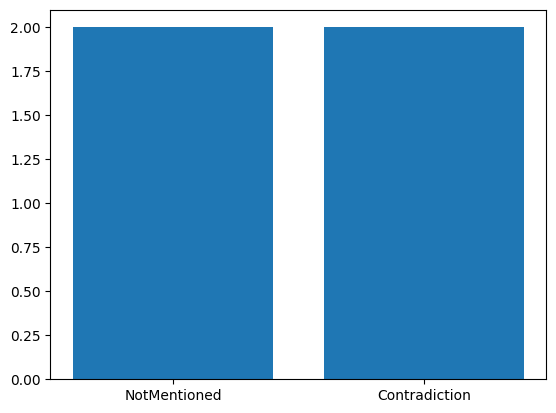

Average document length for testing : 16632.0
Max text length for testing : 16632
Min text length for testing : 16632
Median text length for testing : 16632.0


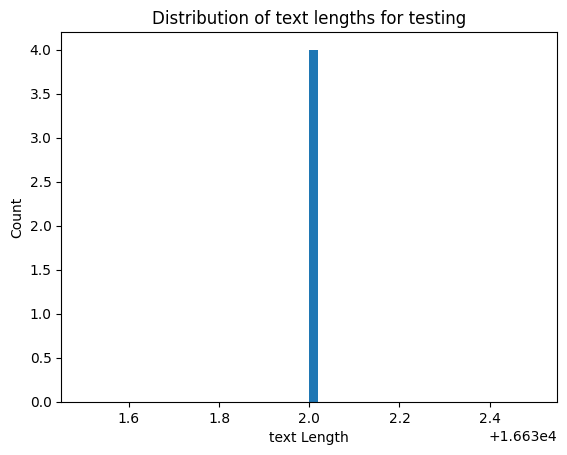

Average document length for testing : 86.25
Max hypothesis length for testing : 112
Min hypothesis length for testing : 66
Median hypothesis length for testing : 83.5


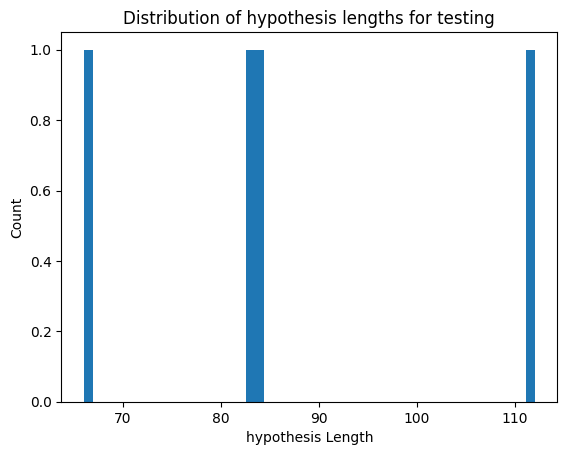

In [53]:
## ALBERT model
visualize_label(albert_errors, "testing")
visualize_features(albert_errors, "testing", "text", "text")
visualize_features(albert_errors, "testing", "hypothesis", "hypothesis")


The type of dataset: testing
The count of each type of values: 
 labels
NotMentioned     2
Contradiction    2
Name: count, dtype: int64


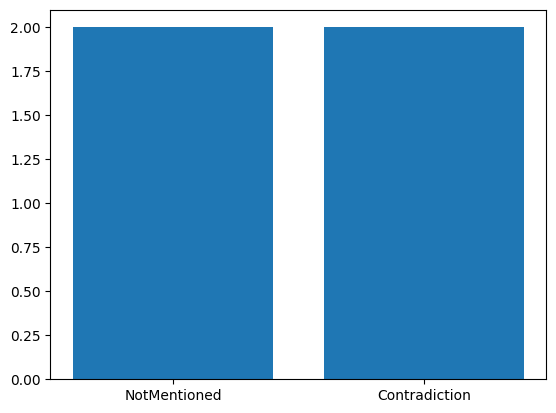

Average document length for testing : 16632.0
Max text length for testing : 16632
Min text length for testing : 16632
Median text length for testing : 16632.0


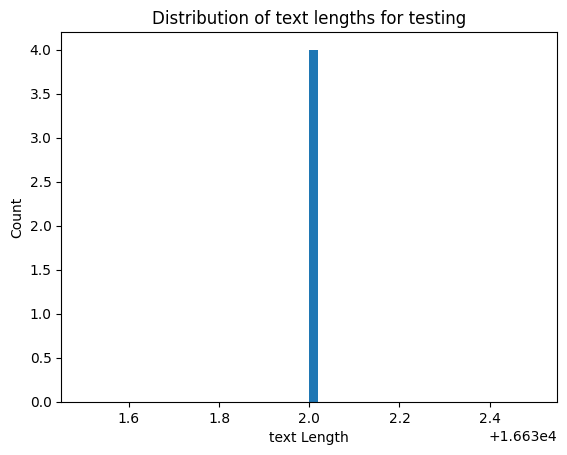

Average document length for testing : 86.25
Max hypothesis length for testing : 112
Min hypothesis length for testing : 66
Median hypothesis length for testing : 83.5


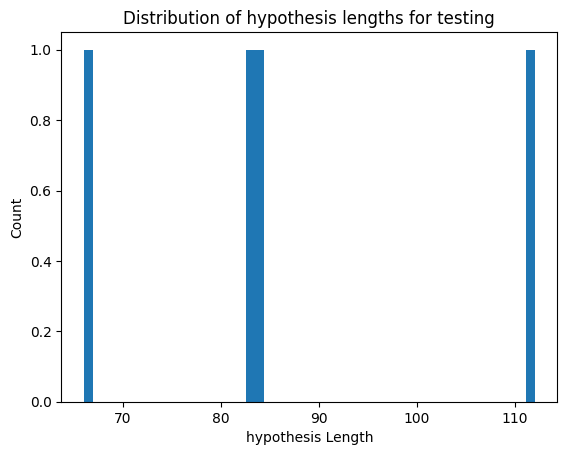

In [54]:
## DistilBERT model
## ALBERT model
visualize_label(distilbert_errors, "testing")
visualize_features(distilbert_errors, "testing", "text", "text")
visualize_features(distilbert_errors, "testing", "hypothesis", "hypothesis")
